In [173]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
#%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
plt.style.use('seaborn-white')
# colorblind safe
plt.style.use('seaborn-colorblind')
plt.style.use('tableau-colorblind10')

# width and precision for f strings
width = 10
precision = 4

# default sizes for plots
# https://matplotlib.org/3.3.0/tutorials/introductory/customizing.html#customizing-with-matplotlibrc-files
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['font.size'] = 16
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['lines.linewidth'] = 2

# other settings
pd.options.display.float_format = '{:,.4f}'.format
pd.set_option("display.precision", 3)
np.set_printoptions(precision=3, suppress=True)
%load_ext autoreload
%autoreload 2
pd.set_option('display.max_columns', None)
%config IPCompleter.greedy=True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [3]:
data = pd.read_csv('../data/USdata_est_campgrounds_zip_states_combined_cleaned.csv')
data.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)

In [4]:
# maybe just do for state subset I have images for
states = ['CO', 'CA', 'AZ', 'OR', 'UT', 'WA']
data_states = data[data['State'].isin(states)].copy()

In [5]:
len(data_states)

5364

In [6]:
data_states.groupby(['State'])['Description'].agg('count')

State
AZ     886
CA    1698
CO     707
OR     729
UT     651
WA     692
Name: Description, dtype: int64

In [7]:
data_states.groupby(['Category'])['Description'].agg('count')

Category
Eco-Friendly                16
Established Campground    1408
Informal Campsite          887
Short-term Parking          11
Showers                    139
Water                      253
Wild Camping              2649
Name: Description, dtype: int64

In [8]:
data_states = data_states[~data_states['Description'].isna()]

In [9]:
data_states.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5363 entries, 0 to 12411
Data columns (total 38 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Location                   1077 non-null   object 
 1   Name                       5363 non-null   object 
 2   Category                   5363 non-null   object 
 3   Description                5363 non-null   object 
 4   Latitude                   5363 non-null   float64
 5   Longitude                  5363 non-null   float64
 6   Altitude                   5276 non-null   float64
 7   Date verified              5363 non-null   object 
 8   Open                       5363 non-null   object 
 9   Electricity                4944 non-null   object 
 10  Wifi                       4944 non-null   object 
 11  Kitchen                    4944 non-null   object 
 12  Parking                    0 non-null      float64
 13  Restaurant                 4944 non-null   obje

In [10]:
descriptions = data_states['Description']

In [66]:
tfidf = TfidfVectorizer(stop_words='english')
desc_tfidf_matrix = tfidf.fit_transform(data_states['Description'])

In [12]:
# desc_tfidf_matrix.todense() what does this do?

In [67]:
# features = tfidf.vocabulary_.keys()
# or better:
features = tfidf.get_feature_names()
len(features)

9493

In [68]:
km = KMeans(8)
y = km.fit_predict(desc_tfidf_matrix)

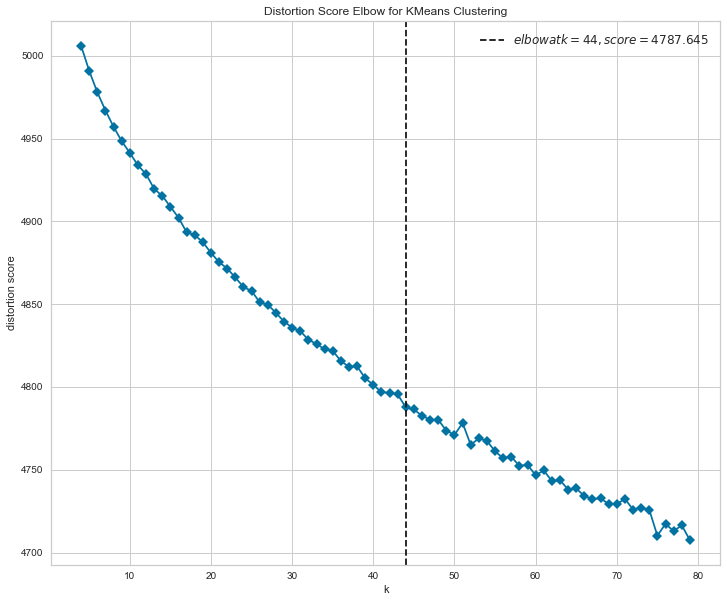

In [41]:
from yellowbrick.cluster import KElbowVisualizer
fig, ax = plt.subplots(1, figsize=(12, 10))
visualizer = KElbowVisualizer(km, k=(4,80), timings=False, metric='distortion', show=False, ax=ax) # default is distortion

visualizer.fit(desc_tfidf_matrix)        # Fit the data to the visualizer
visualizer.show(outpath="../images/elbow_distortion_some_states.png");      # Finalize and render the figure

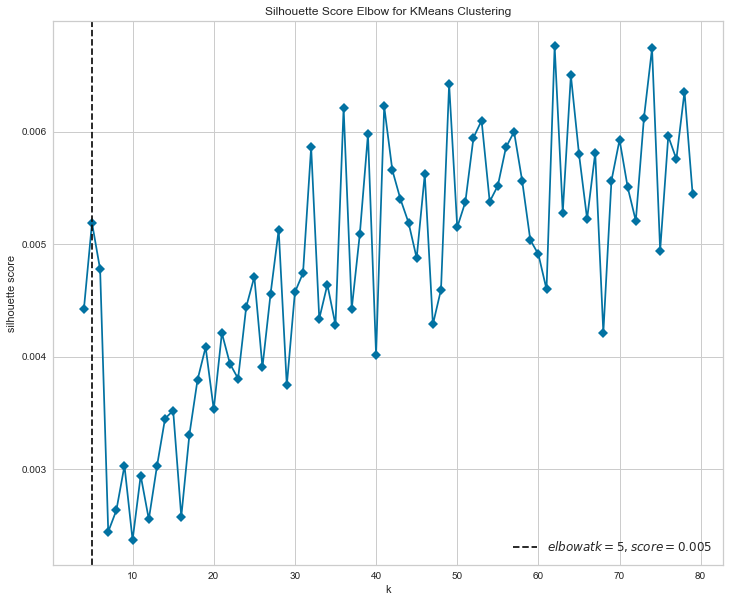

In [39]:
fig, ax = plt.subplots(1, figsize=(12, 10))

visualizer = KElbowVisualizer(km, k=(4,80), timings=False, metric='silhouette', show=False, ax=ax) # default is distortion

visualizer.fit(desc_tfidf_matrix)        # Fit the data to the visualizer
visualizer.show(outpath="../images/elbow_some_states.png");        # Finalize and render the figure

In [15]:
km.cluster_centers_

array([[0.001, 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.016, 0.   , 0.   , ..., 0.   , 0.   , 0.001],
       [0.002, 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.001, 0.001, 0.   , ..., 0.   , 0.   , 0.   ],
       [0.006, 0.001, 0.   , ..., 0.   , 0.   , 0.   ]])

In [16]:
km.labels_

array([5, 3, 1, ..., 2, 3, 2], dtype=int32)

In [69]:
silhouette_score(desc_tfidf_matrix, labels=y)

0.006673532114238733

In [82]:
km = KMeans(3)
y = km.fit_predict(desc_tfidf_matrix)
silhouette_score(desc_tfidf_matrix, labels=y)

0.007495957526154937

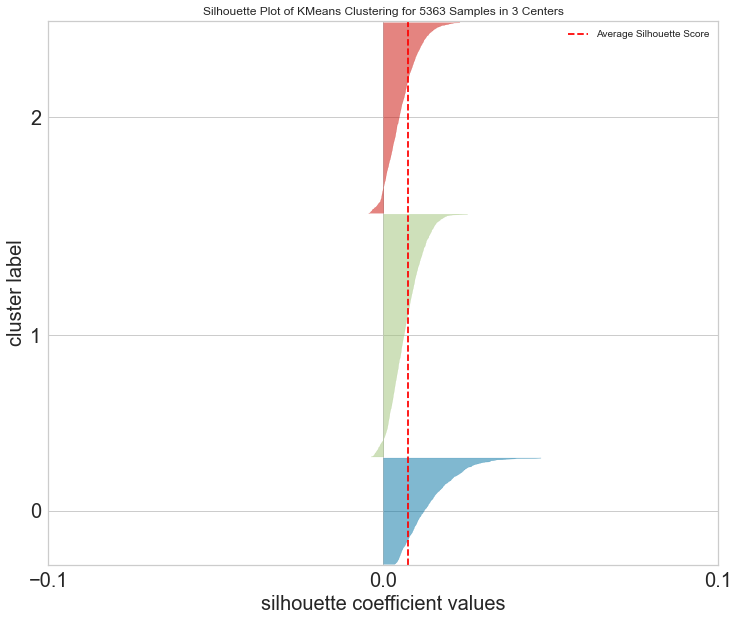

In [83]:
from yellowbrick.cluster import silhouette_visualizer
fig, ax = plt.subplots(1, figsize=(12, 10))
ax.set_xlim(-0.05, .1)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
ax.set_title('', fontsize=20)
visualizer = silhouette_visualizer(km, desc_tfidf_matrix, colors='yellowbrick', show=False, ax=ax) 
#visualizer.show()
#visualizer.show(outpath="../images/sil_plot_some_states_k4_best.png");

In [84]:
top_10_centroids = km.cluster_centers_.argsort()[:,-1:-11:-1]
top_10_centroids

array([[6099, 5072, 6009, 5697, 6736, 8097, 6093, 7647, 1085, 3657],
       [7145, 7938, 5690, 1832, 7940, 3601, 6736, 4688, 3930, 1085],
       [9145, 1826, 7683, 7610, 5690, 3657, 6093, 5697, 8506, 4298]])

In [85]:
for num, centroid in enumerate(top_10_centroids):
    print(f"{num}, {', '.join(features[i] for i in centroid)}")

0, parking, lot, overnight, night, quiet, street, park, signs, area, free
1, road, spot, nice, camping, spots, forest, quiet, just, great, area
2, water, campground, sites, showers, nice, free, park, night, toilets, hot


In [138]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=10_000, max_df=.9)
X = vectorizer.fit_transform(data_states['Description'])
print(f'size of vectorizer is: {X.shape[1]}')
features = vectorizer.get_feature_names()
kmeans = KMeans(7)
kmeans.fit(X)
top_centroids = kmeans.cluster_centers_.argsort()[:,-1:-16:-1]
print("\ntop 15 features for each cluster with 10,000 max features:\n")
for num, centroid in enumerate(top_centroids):
    print(f"{num}: {', '.join(features[i] for i in centroid)}")


size of vectorizer is: 9493

top 15 features for each cluster with 10,000 max features:

0: forest, national, road, service, camping, campground, free, nice, spots, quiet, spot, river, camp, dispersed, miles
1: water, station, potable, dump, free, hose, spigot, gas, gallon, park, drinking, air, area, available, rest
2: road, spot, dirt, spots, just, nice, right, pull, great, little, quiet, views, gravel, good, camping
3: night, place, area, quiet, camping, nice, good, free, spot, great, park, highway, just, beautiful, large
4: sites, campground, nice, toilets, river, water, pit, tables, night, lake, free, site, picnic, tent, park
5: parking, lot, overnight, street, quiet, night, park, signs, free, area, big, rv, stayed, walmart, parked
6: showers, hot, shower, park, clean, rv, wifi, nice, laundry, campground, pool, night, tent, water, site


In [117]:
# I like the model in previous cell the best
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

svd = TruncatedSVD(n_components=2000)
svd.fit(X)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
X_SVD = lsa.fit_transform(X)
explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD: {}%".format(int(explained_variance * 100)))
# original_space_centroids = svd.inverse_transform(km.cluster_centers_)
# order_centroids = original_space_centroids.argsort()[:, ::-1]

Explained variance of the SVD: 88%


In [129]:
# do the k means on the SVD
from sklearn import metrics
kmeans = KMeans(7)
kmeans.fit(X_SVD)

print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, kmeans.labels_, sample_size=1000))

original_space_centroids = svd.inverse_transform(kmeans.cluster_centers_)
order_centroids = original_space_centroids.argsort()[:, ::-1]

Silhouette Coefficient: 0.007


In [136]:
for i in range(7):
    print(f"\nCluster {i}:")
    for ind in order_centroids[i, :10]:
        print(' %s' % features[ind], end='')


Cluster 0:
 parking lot overnight street quiet night park signs free area
Cluster 1:
 campground sites lake toilets nice pit forest tables water free
Cluster 2:
 road spot dirt forest spots just nice camping service pull
Cluster 3:
 night place quiet area nice good spot camping great free
Cluster 4:
 showers hot park shower clean rv nice campground wifi tent
Cluster 5:
 water station potable dump free hose spigot gas gallon park
Cluster 6:
 river road nice sites right campground spot access pit free

In [163]:
# Fit the NMF model
from sklearn.decomposition import NMF
# this is slow.. maybe need to limit features more?
nmf = NMF(n_components=10, max_iter=500, verbose=True, alpha=0.1, l1_ratio=.5).fit(X) # alpha=.1, l1_ratio=.5,

violation: 1.0
violation: 0.25167344082367465
violation: 0.1871067791607711
violation: 0.13949964105368465
violation: 0.10198199763506252
violation: 0.07548742277237769
violation: 0.058183763001470774
violation: 0.047059755507737416
violation: 0.03934790772487873
violation: 0.034344829709921955
violation: 0.030793993952495262
violation: 0.02820889488224074
violation: 0.026345644674001103
violation: 0.024731502609040983
violation: 0.023623329506539992
violation: 0.02274125268043197
violation: 0.02193772826049089
violation: 0.02126347718219097
violation: 0.020615754324786247
violation: 0.019921710471618125
violation: 0.01905172706527909
violation: 0.01824441562795502
violation: 0.017446771886316575
violation: 0.01667972541343124
violation: 0.015918707052989273
violation: 0.015162492253763132
violation: 0.014424267256802554
violation: 0.013624955199322906
violation: 0.012830039320240573
violation: 0.01206728945612605
violation: 0.011329561794914598
violation: 0.010620111362268694
violatio

In [169]:
print('reconstruction error:', nmf.reconstruction_err_)

reconstruction error: 70.5807071357621


In [164]:
for topic_idx, topic in enumerate(nmf.components_):
    print(f'"Topic # {topic_idx}:')
    print(" ".join([features[i] for i in topic.argsort()[:-20 - 1:-1]]))

"Topic # 0:
road spot dirt spots forest just great service camping views pull right flat small camp cell gravel little beautiful creek
"Topic # 1:
parking lot overnight street signs quiet park big walmart rv casino parked sign stayed stay allowed space near nights gravel
"Topic # 2:
sites campground toilets pit tables lake picnic forest site toilet rings pits creek established national service available small 20 lots
"Topic # 3:
water station potable dump hose gas spigot drinking available gallon air bathrooms tank propane toilets fountain filling fresh refill restrooms
"Topic # 4:
showers park rv hot clean tent shower wifi laundry pool hookups beach 25 bathrooms state site paid minutes available 50
"Topic # 5:
night good quiet place highway stayed close ok traffic spend noise sleep noisy stay stop near cars parked problem walmart
"Topic # 6:
free camping blm spots quiet facilities forest national amenities toilet land dispersed 14 campsite days services campsites wifi camp park
"Topic

In [165]:
# W = nmf.fit_transform(X)
# H = nmf.components_
def fit_nmf(r, X):
    nmf = NMF(n_components=r, max_iter=500, verbose=False, alpha=0.1, l1_ratio=.5)
    nmf.fit(X)
    return nmf.reconstruction_err_

reconstruction error: 70.5807071357621


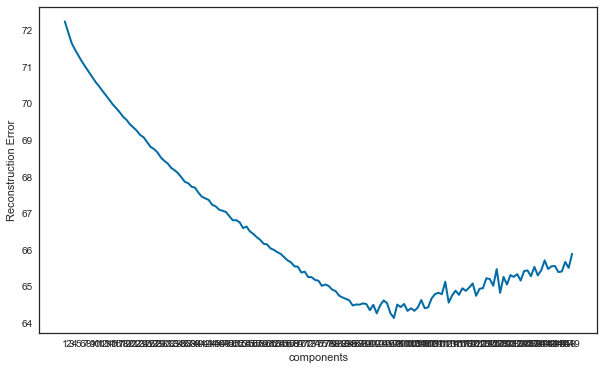

In [174]:
start = 1
end = 150
error = [fit_nmf(i, X) for i in range(start,end)]
plt.plot(range(start,end), error)
plt.xticks(range(start, end))
plt.xlabel('components')
plt.ylabel('Reconstruction Error')
plt.savefig(f'../images/NMF_reconstruction_error_{end}_components_.png')

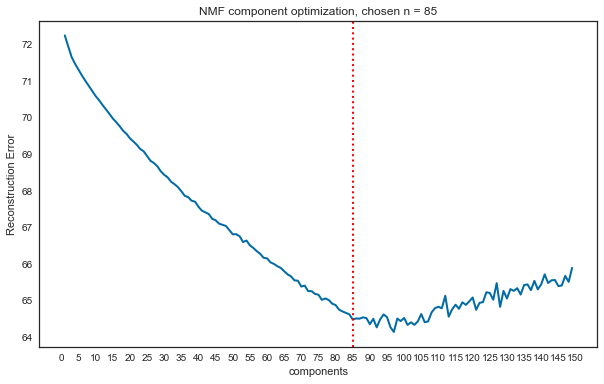

In [203]:
plt.plot(range(1,150), error)
plt.axvline(85, linestyle='dotted', color='red')
plt.xticks(range(0, 155, 5))
plt.xlabel('components')
plt.ylabel('Reconstruction Error')
plt.title('NMF component optimization, chosen n = 85')
plt.savefig(f'../images/NMF_reconstruction_error_{end}_components_fix_xaxis.png')

In [189]:
error_zoom = error[50:]
start = 50
end = 149

Text(0, 0.5, 'Reconstruction Error')

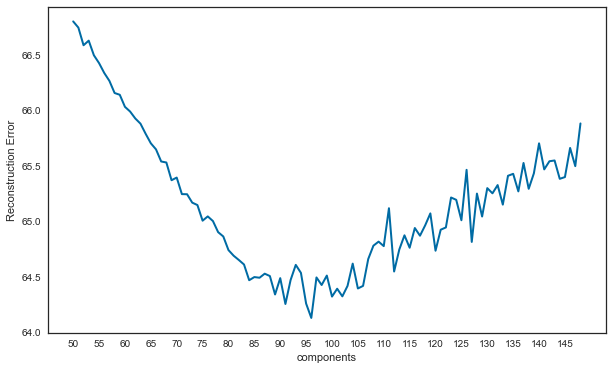

In [195]:
plt.plot(range(start, end), error_zoom)
plt.xticks(range(start, end, 5))
plt.xlabel('components')
plt.ylabel('Reconstruction Error')
# plt.savefig(f'../images/NMF_reconstruction_error_{end}_components_zoomed.png')

In [204]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(data_states['Description'])
# or this?
#X = vectorizer.fit_transform(df_raw['content']).todense()
features = vectorizer.get_feature_names()
kmeans = KMeans(85)
kmeans.fit(X)
top_centroids = kmeans.cluster_centers_.argsort()[:,-1:-16:-1]
print("\ntop 15 features for each cluster with no max features:\n")
for num, centroid in enumerate(top_centroids):
    print(f"{num}: {', '.join(features[i] for i in centroid)}")


top 15 features for each cluster with no max features:

0: firepit, wood, site, road, nice, spot, single, lake, stone, small, easy, dry, near, verizon, lots
1: rest, area, highway, picnic, machines, bathrooms, tables, vending, parking, trucks, overnight, toilets, clean, water, restrooms
2: lake, campground, toilets, pit, sites, forest, access, near, fishing, tables, boat, site, middle, redwoods, sure
3: laundry, pool, showers, 45, good, campground, rv, wifi, clean, nice, swimming, night, hot, resort, park
4: noisy, bit, highway, close, night, little, free, road, just, stayed, problem, parking, place, area, street
5: people, small, camp, road, camping, lot, area, place, just, parking, park, ground, spot, water, night
6: like, looks, road, spot, gravel, cell, service, used, river, spots, good, lots, right, pit, just
7: pack, camping, road, area, lots, land, quiet, roads, primitive, dirt, dispersed, sand, nice, room, spots
8: road, private, camp, right, spot, property, gravel, leads, sit

In [138]:
assigned_cluster = kmeans.transform(X).argmin(axis=1)
for i in range(kmeans.n_clusters):
    cluster = np.arange(0, X.shape[0])[assigned_cluster==i]
    sample_sites = np.random.choice(cluster, 5, replace=False)
    print(f"\ncluster {i}:")
    for site in sample_sites:
        site_row = data_states.iloc[site]
        print(site_row[2], '\n', site_row[3], '\n')


cluster 0:
Established Campground 
 Small sites, I think tent sites but I’m in a 40’mh towing.  No guidance on the sites.  $12/nt on a small lake with gorgeous sunsets.  

Established Campground 
 Nice campground by the lake. Was the only place we found 'open' end of october. There was no sign that it was closed and several people dropped by during the day. There are restrooms but these were locked when we were there. Nice views on the lake, fire pits, tables and further from the road than the other campsite down the road.  

Wild Camping 
 A spot with a view of Lake Casitas. Stayed here night no issues 

Established Campground 
 Lake Jennings is known for being one of the most scenic parks in all of San Diego County. It is a welcoming recreation destination located in Lakeside, California offering fishing, camping, hiking, and picnicking activities. The lake is a drinking water reservoir owned and operated by Helix Water District. The scenic views of the lake and the wooded surroundi

In [151]:
# count sites of each categories in each cluster 
from collections import Counter
kmeans = KMeans(n_clusters=8)
kmeans.fit(X)
assigned_cluster = kmeans.transform(X).argmin(axis=1)

for i in range(kmeans.n_clusters):
    cluster = np.arange(0, X.shape[0])[assigned_cluster==i]
    categories = data_states.iloc[cluster]['Category']
    most_common = Counter(categories).most_common()
    print(f"Cluster {i}:")
    for j in range (len(most_common)):
        print(f"     {most_common[j][0]} ({most_common[j][1]} categories)")

Cluster 0:
     Wild Camping (207 categories)
     Established Campground (60 categories)
     Informal Campsite (55 categories)
     Showers (3 categories)
     Water (2 categories)
     Eco-Friendly (1 categories)
Cluster 1:
     Informal Campsite (408 categories)
     Wild Camping (277 categories)
     Established Campground (26 categories)
     Water (10 categories)
     Short-term Parking (8 categories)
     Showers (3 categories)
Cluster 2:
     Wild Camping (1028 categories)
     Informal Campsite (274 categories)
     Established Campground (232 categories)
     Water (19 categories)
     Eco-Friendly (14 categories)
     Showers (2 categories)
     Short-term Parking (2 categories)
Cluster 3:
     Water (216 categories)
     Established Campground (46 categories)
     Informal Campsite (26 categories)
     Wild Camping (18 categories)
     Showers (4 categories)
     Eco-Friendly (1 categories)
     Short-term Parking (1 categories)
Cluster 4:
     Established Campground (416 

In [ ]:
# do NMF approach
from sklearn.decomposition import NMF
nmf = NMF(n_components=10, init='random')
nmf.fit(X)
H_sk = nmf.components_
top_tokens_sk = top_tokens_nmf(H_sk,tokens,15,print_=True)
cluster_categories = ['law', 'middle_east_politics', 'baseball', 'european_politcs',
                'terrorism', 'football', 'maritime_sports', 'economy', 'us_politics', 'art']

nmf = NMF_sklearn(n_components=7, max_iter=100, random_state=12345, alpha=0.0)
W = nmf.fit_transform(X)
H = nmf.components_
print('reconstruction error:', nmf.reconstruction_err_)

hand_labels = hand_label_topics(H, vocabulary)

for i in rand_articles:
    analyze_article(i, contents, web_urls, W, hand_labels)
    
def fit_nmf(r):
    nmf = NMF(n_components=r, max_iter=500, verbose=True)
    nmf.fit(result)
    W = nmf.transform(result)
    H = nmf.components_
    return nmf.reconstruction_err_

start = 1
end = 70
error = [fit_nmf(i) for i in range(start,end)]
plt.plot(range(start,end), error)
plt.xticks(range(start, end))
plt.xlabel('r')
plt.ylabel('Reconstruction Error')